In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from os import chdir
from glob import glob
import pandas as pd
import glob
import os
import matplotlib

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [8]:
def mergeCSV(file_list):
    df_merge=pd.DataFrame()
    for file in file_list:
        df=pd.read_csv(file, header=None)
        df_merge=pd.concat([df, df_merge], ignore_index=True, sort=False)
    print(df_merge.shape)
    
    return df_merge


file_list=[]
for filepath in glob.iglob(r'C:/Users/antonebert/Desktop/WS2021 Programing/MADI/Activity Recognition from Single Chest-Mounted Accelerometer/*.csv'):
    file_list.append(filepath)

df=mergeCSV(file_list)
df.columns=['Sequence','x','y','z','label']
df=df.drop(columns=['Sequence'])

df=df[df["label"] != 0] #data cleaning: Leaving out unlabeled data || (3719, 4)
print(df.shape)

df.head

(1926896, 5)
(1923177, 4)


<bound method NDFrame.head of             x     y     z  label
0        2287  2948  2189      1
1        2249  2677  2046      1
2        2270  2568  2005      1
3        2222  2565  2003      1
4        2235  2571  2074      1
...       ...   ...   ...    ...
1926890  1926  2382  2072      7
1926891  1927  2388  2074      7
1926892  1930  2383  2074      7
1926893  1929  2385  2076      7
1926894  1926  2385  2078      7

[1923177 rows x 4 columns]>

## Data are separated by participant
Each file contains the following information
sequential number, x acceleration, y acceleration, z acceleration, label
Labels are codified by numbers

1: Working at Computer

2: Standing Up, Walking and Going updown stairs

3: Standing

4: Walking

5: Going UpDown Stairs

6: Walking and Talking with Someone

7: Talking while Standing


#### Class Distribution 

<AxesSubplot:xlabel='label', ylabel='count'>

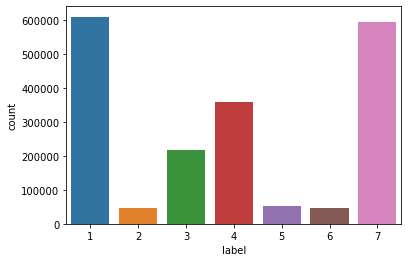

In [9]:
sns.countplot(x = 'label', data=df)

<AxesSubplot:xlabel='label', ylabel='count'>

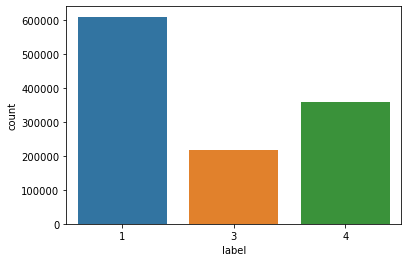

In [10]:
# For Class 1, 3 and 4
options=[1,3,4]
df3class= df.loc[df['label'].isin(options)]
sns.countplot(x = 'label', data=df3class)

In [11]:
#Create input output data
X = df3class.iloc[:, 0:-1]
y = df3class.iloc[:, -1]

<bound method NDFrame.head of            x     y     z  label
0       1969  2373  2121      1
1       1971  2373  2125      1
2       1961  2343  2099      1
3       2019  2352  1873      1
4       1894  2339  1846      1
...      ...   ...   ...    ...
650206  2111  2503  1981      4
650207  1754  2371  1983      4
650208  1824  2278  1955      4
650209  1882  2531  2042      4
650210  2012  2277  1971      4

[650211 rows x 4 columns]>


<AxesSubplot:xlabel='label', ylabel='count'>

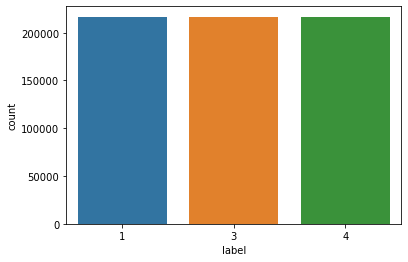

In [12]:
#Under Sample
rus= RandomUnderSampler(random_state=0)
rus.fit(X,y)
X_resampled, y_resampled = rus.fit_sample(X,y)
df_resample = pd.concat([X_resampled,y_resampled], axis = 1)
print(df_resample.head)
sns.countplot(x = 'label', data=df_resample)

In [13]:
# Split into train+val (80%) and test(20%)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69) 

# implementing train-test-split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=66)

In [14]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
# random forest model creation
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
# predictions
rfc_predict = rfc.predict(X_test)

In [15]:
rfc_cv_score = cross_val_score(rfc, X, y, cv=7)

In [16]:
print("=== Confusion Matrix ===")
confusion_matrix=confusion_matrix(y_test, rfc_predict)
confusion_matrix=(confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis])
print(np.round(confusion_matrix,2))
#print(confusion_matrix)
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[0.9  0.04 0.05]
 [0.04 0.71 0.24]
 [0.06 0.17 0.77]]


=== Classification Report ===
              precision    recall  f1-score   support

           1       0.90      0.90      0.90     71323
           3       0.77      0.71      0.74     71525
           4       0.72      0.77      0.75     71722

    accuracy                           0.80    214570
   macro avg       0.80      0.80      0.80    214570
weighted avg       0.80      0.80      0.80    214570



=== All AUC Scores ===
[0.55166821 0.69795885 0.43347896 0.68868248 0.469359   0.43994933
 0.3563496 ]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.5196352036587882


<AxesSubplot:>

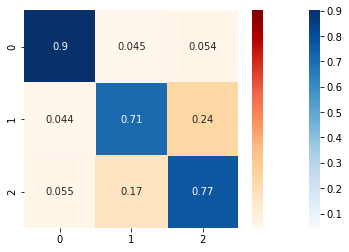

In [17]:
vmin = np.min(confusion_matrix)
vmax = np.max(confusion_matrix)
off_diag_mask = np.eye(*confusion_matrix.shape, dtype=bool)

fig = plt.figure()
sns.heatmap(confusion_matrix, annot=True, mask=~off_diag_mask, cmap='Blues', vmin=vmin, vmax=vmax)
sns.heatmap(confusion_matrix, annot=True, mask=off_diag_mask, cmap='OrRd', vmin=vmin, vmax=vmax, cbar_kws=dict(ticks=[]))

<AxesSubplot:>

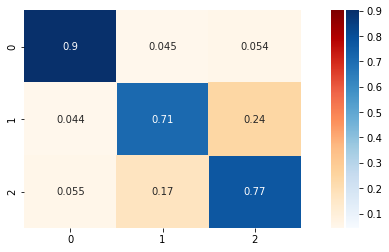

In [18]:
fig = plt.figure()
gs0 = matplotlib.gridspec.GridSpec(1,2, width_ratios=[20,2], hspace=0.05)
gs00 = matplotlib.gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gs0[1], hspace=0)

ax = fig.add_subplot(gs0[0])
cax1 = fig.add_subplot(gs00[0])
cax2 = fig.add_subplot(gs00[1])

sns.heatmap(confusion_matrix, annot=True, mask=~off_diag_mask, cmap='Blues', vmin=vmin, vmax=vmax, ax=ax, cbar_ax=cax2)
sns.heatmap(confusion_matrix, annot=True, mask=off_diag_mask, cmap='OrRd', vmin=vmin, vmax=vmax, ax=ax, cbar_ax=cax1, cbar_kws=dict(ticks=[]))

Data are separated by participant
Each file contains the following information sequential number, x acceleration, y acceleration, z acceleration, label Labels are codified by numbers

1: Working at Computer

2: Standing Up, Walking and Going updown stairs

3: Standing

4: Walking

5: Going UpDown Stairs

6: Walking and Talking with Someone

7: Talking while Standing